# Bayesian neural network with variational inference

In this notebook we will implement a Bayesian neural network using variational inference. We will follow the paper *Weight Uncertainty in Neural Networks*  (arXiv:1505.05424v2) and their proposed *Bayes by Backdrop* algorithm for the implementation of a backpropagation compatible algorithm for learning the probability distribution over the weights. We will work on a simple linear regression task, following the experiment presented in the paper. 

## Introduction 

Standard feedforward neural networks (NN) are prone to overfitting. This happens when the size of the training data set is too small, or when the complexity of our chosen model exceeds the complexity of the true distribution. Moreover, when classical NNs are applied to supervised learning tasks, they're overconfident in their predictions, particularly in regions of unknown phase space (e.g. when asked to classify an image belonging to a class the network wasn't traind on). 

Bayesian neural networks (BNNs) introduce uncertainy in the weights of the network. According to standard Bayesian methods, the weights are treated as stochastic variables described by probability distributions. A BNN is trained to learn a distribution over the weights, rather than a single point estimate as in a classical NN. The Bayesian treatment of the weights acts as a regularizer preventing overfitting. It also results in reacher learnt representations and predictions, since the final prediction is given as the averaging of an ensemble of networks, each defined by a set of weights drawn from the learnt probability distribution. Network ensembling gives also a better way to evaluate the uncertainty, taking into account the epistemic uncertainty due to the uncertainty in the weights. 

## A classical feedforward neural network

In a supervised learning problem we have a training dataset $D$ composed of inputs features $X$ and input targets $Y$. Given $\mathbf{x} \in X$ and $y \in Y$, the goal is to find a mapping $f$ such that $y = f(\mathbf{x})$. 

A machine learning algorithm, given a data set $D$, returns the approximation $\hat{f} = \mathcal{A}(D)$. The quality of the prediction is measured by a loss function $J = J(y, \hat{f}(\mathbf{x}))$. The learning is formulated as an optimization problem over the model parameters to minimize the loss function. 

 In the case of neural networks, $\hat{f} = NN_{\mathbf{w}}$, the network architecture. The network architecture is defined by the number of hidden layers, hidden units, and activation functions. The output of the first hidden layer with $n$ neurons is given by the affine trasformation $A(\mathbf{x}) = W^T \mathbf{x} + \mathbf{b}$ followed by a nonlinear transformation by a monotonic activation function $h(\mathbf{x}) = s(A(\mathbf{x}).$ This operaton is then cascaded over all the L hidden layers $\hat{f} (\mathbf{x}) = h_L ( ...(h_1(\mathbf{x})))$.

The output $\hat{f}$ of the network is not necessarily directly a predicton of the value $y$. Instead, $\hat{f}$ provides the parameters of a distribution over $y$, $p(y | \mathbf{x}, \mathbf{w})$. Thus, when we define our model, we need also to define the probabilistic model $p(y | \mathbf{x}, \mathbf{w})$. In general, the cost function is obtained by applying the principle of maximum likliehood: given the network output $\hat{f}(\mathbf{x})$, we define the loss as $-\text{log} p(\mathbf{y}; \mathbf{x}, \mathbf{w})$ and the optimization procedure consists in finding the parameters $\mathbf{w}$ that minimize this loss 

$$\mathbf{w}_{ML} = \underset{\mathbf{w}}{\arg \max} \ \text{log} p(Y|X,\mathbf{w}).$$

Regularization is often implemented by adding a prior over the weights and finding the maximum a posteriori (MAP) 

$$
 \begin{aligned}
\mathbf{w}_{MAP} &= \underset{\mathbf{w}}{\arg \max} \ \text{log} p(\mathbf{w}|D)\\
&=\underset{\mathbf{w}}{\arg \max} \ \text{log} p(D |\mathbf{w}) + \text{log}p(\mathbf{w}).
 \end{aligned}$$

For a regression task $Y$ is a set of points $y \in \mathbb{R}$ and $p(y | \mathbf{x},\mathbf{w})$ is a Gaussian distribution with mean given by $\hat{f} = NN_{\mathbf{w}}$, which corresponds to a MSE loss. For a classification task, $Y$ is a set of classes and $p(y | \mathbf{x}, \mathbf{w})$ is a categorical distribution, which corresponds to a cross-entropy loss function. 

The training is divided into two steps. During the *forward pass*, the network reads the input $\mathbf{x}$, produces the output $\hat{f}(\mathbf{x})$ and evaluates the cost function $J(\mathbf{x},\mathbf{w})$. In this step information flows forward through the network. The second step is called *back-propagation*. During this step information from the cost flows backward through the network to calculate the gradient. To compute the gradient the **backdrop** algorothm is generally used. Stochastic gradient descent is then implemented to perform the learning,updating the model parameters. The estimate of the gradient is computed on a mini-batch of $m$ examples as

$$\mathbf{g} = \nabla_{\mathbf{w}} J(\mathbf{w})  = \frac{1}{m} \nabla_{\mathbf{w}}\sum_{i=1}^{m} L(\mathbf{x}^{(i)},y^{(i)},\mathbf{w}).$$

Here $L$ is the per-example loss. 
The update follows the estimated gradient downhill

$$\mathbf{w}^{new} = \mathbf{w} - \alpha\mathbf{g}$$

where $\alpha$ is the learning rate. 

Both MAP and MLE inference give only point estimates of the parameters so that predictions are made using only the best performing model on the training data set $NN_{\mathbf{w}_{ML/MAP}}$. However, this is inherently prone to overfitting the training dataset, resulting in poor generalization power. 

## Bayesian neural network



Bayesian inference for neural networks calculates the posterior distribution of the weights $p(\mathbf{w} | D)$. Having a distribution allows us to take weight uncertainty into account when we make predictions. The predictive posterior distribution of an unknown target $y$ given a new input $\mathbf{x}$ is given by 

$$p(y|\mathbf{x}^*) = \int p(y | \mathbf{x}, \mathbf{w})p(\mathbf{w}|D) d\mathbf{w} = \mathbb{E}_{p(\mathbf{w}|D)}p(y | \mathbf{x}, \mathbf{w}). $$

Each possible configuraton of the weights weighted by their posterior probabilities is used to make a prediction. Thus, taking the expectation over the posterior distribution is equivalent to perform an ensemble average of an infinite number of neural networks. In practice, the result is approximated by classical MC sampling

$$\mathbb{E}_{q(\mathbf{w} | X_{tr},Y_{tr})} p(y|x,\mathbf{w}) \approx \frac{1}{K} \sum_{k=1}^K p(y | \mathbf{x},\mathbf{w}^{(k)}), \ \ \ \ \ \ \mathbf{w}^{(k)} \sim q(\mathbf{w}|\lambda)$$

and the result is summarized by standard statistics

$$\hat{\mathbf{y}} = \frac{1}{|\mathbb{W}|}\sum_{\mathbf{\mathbf{w}}_i \in \mathbb{W}} NN_{\mathbf{w}_i} (\mathbf{x})$$

$$\Sigma_{\mathbf{y} | \mathbf{x},D} = \frac{1}{|\mathbb{W}| - 1} \sum_{ \mathbf{\mathbf{w}}_i \in \mathbb{W}} (NN_{\mathbf{\mathbf{w}}_i}(\mathbf{x}) - \mathbf{\hat{y}}) (NN_{\mathbf{\mathbf{w}}_i}(\mathbf{x}) - \mathbf{\hat{y}})^T $$

### Variational inference

Unfortunately, computing the posterior distribution is not possible for neural networks of any practical size and we need to resort to approximative methods. The most popular method used in the training of BNNs is variational inference. 

The goal is to find a variational distributin $q(\mathbf{w} | \lambda)$that approximates the posterior $p(\mathbf{w} | D)$. Q is generally chosen to belong to a known parametric family described by the parameters $\lambda$. Variational learning consists in finding the values of the variational parameters for which the Kullback-Leibler (KL) divergence between the variational distribution and the true posterior is minimized. 

$$
\lambda^* = \underset{\lambda}{\arg \min} \ KL[ q(\mathbf{w}| \lambda) | p(\mathbf{w} | D)] $$

It can be shown that this is equivalent to maximizing the ELBO, so we define our cost function as negative the ELBO:

$$ J(\mathbf{x}, \mathbf{w}) = KL[ q(\mathbf{w}| \lambda) | p(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w} | \lambda)} [ \text{log} p(D | \mathbf{w})]$$

The first term is prior-dependent and is called regularizer, while the second term data-dependent and is called likelihood cost. We see that minimizing this cost function is a tradeoff between keeping the model cmplexity low and close to the prior, and satisfying the complexity of the data. 

It can be shown that the these two terms can be expressed as expectations with respect to the variational distribution. 

$$J(\mathbf{w}, D) = \mathbb{E}_{q(\mathbf{w} | \lambda)} \text{log}q(\mathbf{w}|\lambda) -\mathbb{E}_{q(\mathbf{w} | \lambda)} \ \text{log} p(D | \mathbf{w} )  - \mathbb{E}_{q(\mathbf{w} | \lambda)} \text{log} p(\mathbf{w})$$

In a BNN the expectations in the cost function are approximated by drawing $N$ sampled $\mathbf{w}^{(i)}$ from $q(\mathbf{w} | \lambda)$ 

$$J(D, \mathbf{w})\approx \frac{1}{N} \sum_{i=1}^{N}[ -\text{log} p(D | \mathbf{w}^{(i)} ) + \text{log}q(\mathbf{w}^{(i)}|\lambda)  - \text{log} p(\mathbf{w}^{(i)}) ].$$

Sampling only one weight, so $N=1$, is usually enough to obtain good performance. 




### Mini-batch gradient descent
This cost function is applicable to mini-batch optimization. Recall that in Mini-batch Gradient Descent the training dataset is divided in M *mini-batches* $D_i$, each containing a number of examples given by the hyperparameter *batch_size*. At each gradient update, the loss is calculated as the average over all the examples in a minibatch.One epoch is comprised of mini-batches. After one epoch each example in the training dataset has participated in parameter update. Note that in the cost function the likelihood cost, being data-dependent, needs to be computed at the end of the forward pass on the mini-batch data $D_i$. The other terms are data-independent, so they can be computed layer-wise.  This means that if the training set is divided in $m$ minibatches, then the cost $J_i$ per mini-batch $D_i$ is given by 

$$
 J_i = \frac{1}{m} KL[ q(\mathbf{w}| \lambda) | p(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w} | \lambda)} [ \text{log} p(D_i | \mathbf{w})]
$$

The facort of $\frac{1}{m}$ is necessary so that for each epoch of optimization we get the expected cost function 
$$
\begin{aligned}
J(\mathbf{w}) &= \sum_{i=1}^{m} J_i \\
&= m \cdot \frac{1}{m} KL[ q(\mathbf{w}| \lambda) | p(\mathbf{w})]  + \sum_{i=1}^{m} \mathbb{E}_{q(\mathbf{w} | \lambda)} [ \text{log} p(D_i | \mathbf{w})]\\
&= KL[ q(\mathbf{w}| \lambda) | p(\mathbf{w})] - \mathbb{E}_{q(\mathbf{w} | \lambda)} [ \text{log} p(D | \mathbf{w})].
\end{aligned}$$


### Backpropagation and reparametrization trick 

Backpropagation requires computing local gradients at each node. However, in our model the weights are sampled from the posterior distribution and it is not well defined how to take derivatives with respect to stochastic variables. We saw that our cost function of which we need to take the gradient is a sum of expectations with respect to the variational distribution $q_{\lambda}(\mathbf{w})$ of functions of $\mathbf{w}$. Consider now taking the gradient of one of these terms

$$ \begin{aligned}
\nabla_{\lambda} \mathbb{E}_{q_{\lambda}(\mathbf{w})}f_{\lambda}(\mathbf{w}) &= \nabla_{\lambda}  \int q_{\lambda}(\mathbf{w}) f_{\lambda}(\mathbf{w}) d\mathbf{w}   \\
&=  \int\nabla_{\lambda} q_{\lambda}(\mathbf{w}) f_{\lambda}(\mathbf{w}) d\mathbf{w}\\
&= \underbrace{\int f_{\lambda}(\mathbf{w}) \nabla_{\lambda}  q_{\lambda}(\mathbf{w}) d\mathbf{w}}_{\text{how to compute this?}} + 
\mathbb{E}_{q_{\lambda}(\mathbf{w})} [\nabla_{\lambda} f_{\lambda}(\mathbf{w})] 
\end{aligned}$$


We see that while for the second term the gradient of the expectation is equal to the expectation of the gradient, as it's necessary to approximate the integral with Monte Carlo sampling, this is not the case for the first term. This term is not guaranted to be an expectation. This means that backpropagatin would not compute an estimate of the derivative. Without this condition, we have no guarantee that MC sampling will converge to the right estimate of this term. 
We can solve this by applying the *reparametrizatin trick*. Instead of sampling $\mathbf{w} \sim q(\mathbf{w} | \lambda)$, we let $\mathbf{w} = t(\lambda, \epsilon)$, where $t$ is some deterministic function of the variational parameters and instead we sample $\epsilon \sim p(\epsilon)$. We see that with this substitution, the gradient is back to being well defined:


$$ \begin{aligned}
\nabla_{\lambda} \mathbb{E}_{q_{\lambda}(\mathbf{w})} f_{\lambda}(\mathbf{w})
&= \nabla_{\lambda} \mathbb{E}_{p_{\epsilon}(\mathbf{w})} f_{\lambda}(\mathbf{w} = t(\lambda, \epsilon)) \\
&= \mathbb{E}_{p_{\epsilon}(\mathbf{w})}\nabla_{\lambda}  f_{\lambda}(\mathbf{w} = t(\lambda, \epsilon)) \\
&\approx  \frac{1}{N} \sum_{i=1}^{N} \nabla_{\lambda}f_{\lambda}(\mathbf{w} = t(\lambda, \epsilon)).
\end{aligned}$$


## Linear regression with Bayes by Backdrop

Let's build now a Bayesian neural network to solve a linear regression problem.

### Prior

Following the paper, we choose as prior a scale mixture of two Gaussians. Each density has mean at zero but different variances: 

$$P(\mathbf{w}) = \prod_j \pi \mathcal{N}(\mathbf{w}_j | 0, \sigma_1^2) + (1 - \pi) \mathcal{N}(\mathbf{w}_j | 0, \sigma_2^2). $$

Here $\mathbf{w}_j$ is the $j-th$ weight of the network. The standard deviations of the two gaussians are chosen so that $\sigma_1 > \sigma_2$, so that the first is concentrated at zero, while the second one is more diffuse. Note that all the prior parameters are shared among all the weights. The priors are considered fixed, so their parameters are found via hyperparameter-optimization and are not updated during training.

### Variational posterior
 For the approximate variational posterior distribution we choose a one-dimensional diagonal Gaussian $\mathcal{N} ( \mu, \sigma)$, so that each weight is now described by two parameters. This means that we have doubled the number of parameters we need to train on, but each weight has now its measure of uncertainty $\sigma$. 
 
We first apply the reparametrization trick to allow backpropagation to work. It's a known property of the normal distribution that sampling $w \sim \mathcal{N} ( \mu, \sigma)$ is equivalent to sampling a unit Gaussian $\epsilon \sim \mathcal{N}(0,1)$ and obtaining $\mathcal{w}$ from the deterministic transformation $w = \mu + \epsilon \cdot \sigma$. 

We parametrize the standard deviation as $\sigma = \text{log} ( 1 + \text{exp}(\rho))$, so that $\sigma$ is always non-negative. Thus for each weight we have two variational parameters dscribing the corresponding approximate posterior, $\lambda = (\mu, \rho)$. 

At each optimization step we will do the following: 
   1. Sample $\epsilon \sim \mathcal{N}(0,1)$

   2. Evaluate $w = \mu + \epsilon \cdot \text{log} ( 1 + \text{exp}(\rho))$
   3. Evaluate the loss $J(w, \lambda)_i$
   4. Calculate the gradient with respect to the mean 
    $$ \Delta_{\mu} = \frac{\partial J(w, \lambda)}{\partial w} + \frac{\partial J(w, \lambda)}{\partial \mu} $$
   5. Calculate the gradient with respect to the standard deviation parameter $\rho$ 
    $$ \Delta_{\rho} = \frac{\partial J(w, \lambda)}{\partial w} \frac{\epsilon}{1 + \text{exp}(-\rho)}+ \frac{\partial J(w, \lambda)}{\partial \rho} $$

   6. Update the variational parameters 
    $$ \mu^{new} = \mu - \alpha \Delta_{\mu}$$ 
    $$ \rho^{new} = \rho - \alpha \Delta_{\rho}$$


Note that points $4$, $5$, and $6$ are done for us under the hood by *Keras*. We only need to declare $\mu$ and $\rho$ as trainable parameters for each layer. 

### Training data



(32, 2)
(32, 1)


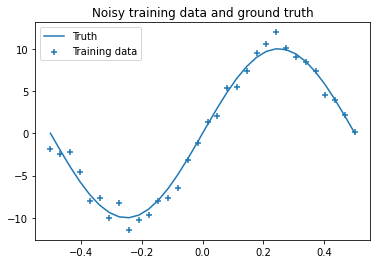

In [364]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1789)
%matplotlib inline

# sinusoidal data generating function
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

# Generate training data
train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
Phi = np.concatenate([np.ones(X.shape),X], axis=1)
print(Phi.shape)
print(X.shape)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

### Implementation of variational layer

In order to train a Bayesian neural network with variational inference we'll need a variational layer. We will define a *DenseVariational* layer by hand, so that we can put into practice what we learned in class. To create a new layer we'll use Keras Layer class. 

The layer is initialized with the number of hidden units we want in the layer, the weight $\frac{1}{m}$ of the *kl_loss* in case we use mini-batches, and the hyperparameters of our model. Note that among the hyperparameters there are the parameters of the Gaussian mixture prior, which we said we would fix before training.

In Keras API the `build(self, inputs_shape)` method allows us to create the layer weights, and in particular it  allows us to instantiate the layer without knowing the size of the input. The `call()` method will automatically run build the first time it is called. In our layer we will have 3 types of weights that are named *kernel_mu*, *kernel_rho* and *bias_mu*. 

Recall that the output of a NN layer is given by $h(\mathbf{x}) =s( W^T \mathbf{x} + \mathbf{b})$. In the code the weights $W$ are referred to as *kernel* and $\mathbf{b}$ is the *bias*. We will obtain a posterior distribution over the weights $W$, while we will treat the bias as a deterministic parameter (we don't define an uncertainty for it). Note that the bias has the dimension of the number of hidden units, since we have one bias term per node, while the kernel ($W$) has dimension `(input_shape, units)`. Each weight $w \in W$ will be parametrized by $w = \mu + \epsilon * \sigma$, where $\sigma$ is defined in terms of $\rho$ as explaind above. Thus our trainable parameters will be the bias vector *bias_mu* and the matrices *kernel_mu* and *kernel_rho*.



The method `add_loss()` can be used to create loss tensors and is called within the `call()` method. These losses work seamlessly with fit(): they get automatically summed and added to the main loss. We use the  `add_loss()` method to define our *kl_loss*, the term in the cost functin that does not depend on the data and that can be computed layer-wise. Note that to compute the *kl_loss* we need to evaluate the variational distribution with the current state of the variational parameters and the prior probability for the given weight.

In [365]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp



class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5,                 
                 **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)


    def build(self, input_shape):
        # define the weights we will train on 

        # mean vector of layer weights
        # shape = (n features per example) x (n hidden units in layer)
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                         trainable=True)   
                    
        # stdv parameter rho of layer weights
        # same shape as kernel_mu
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0), 
                                          trainable=True)
        
        # bias term b of layer: W^T*X + b   
        # shape = (n hidden units)    
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                       trainable=True)

        super().build(input_shape)

    def call(self, inputs, **kwargs):
        # the kernel is a matrix of weights w
        # each w_ij is sampled from p(w_ij)=N(kernel_mu_ij, kernel_sigma_ij)

        #sample epsilon for reparametrization trick
        epsilon = tf.random.normal(self.kernel_mu.shape)

        #get sigma from rho
        kernel_sigma = tf.math.softplus(self.kernel_rho)

        #evaluate (deterministic) weights
        kernel = self.kernel_mu + kernel_sigma * epsilon 

        # add per-layer kl_loss
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma))

        #output of the layer
        return self.activation( K.dot(inputs, kernel) + self.bias_mu) #treat bias as deterministic parameter

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))

        # one-dim gaussian prior:
        #comp_1_dist = tfp.distributions.Normal(0.0, 2.)
        #return K.log(comp_1_dist.prob(w))


### Model definition


Now let's build the model using our custom layer. 

We defin the prior hyperparameters, which have already been optimized for the problem. 

We'll set the `batch_size` equal to the size of the training dataset, since we only need to train on 32 examples per epoch. This means we will be performing batch gradient descent (we have only one mini-batch) and the weight factor will be just $1$. We create our model with two `DenseVariational` hidden layers, each having 20 hidden units, and one `DenseVariational` output layer with one unit. 


Recall that layers are recursively composable, so if you assign a `Layer` instance as attribute of another `Layer`, the outer layer will start tracking the weights of the inner layer. 


In [366]:
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input, Dense
from keras.models import Model

batch_size = train_size
num_batches = train_size / batch_size

kl_weight = 1.0 / num_batches
prior_params = {
    'prior_sigma_1': 1.5, 
    'prior_sigma_2': 0.1, 
    'prior_pi': 0.5 
}

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(1, kl_weight, **prior_params)(x)

model = Model(x_in, x)

Now we can compile and train the model. Note that we use a Gaussian negative log likelihood loss. This corresponds to the *likelihood cost* in our cost function. 

In [367]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.1), metrics=['mse'])
history = model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0);

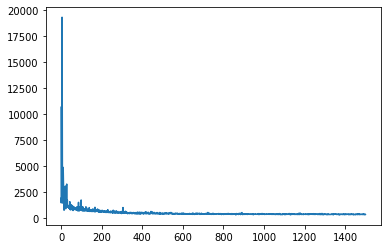

In [368]:
# plot total loss during training
plt.plot(history.history['loss'])

Note how the loss is quite noisy at the beginning. This is expected with the Bayes by backdrop algorithm, because of the small number of samples used to evaluate the cost function. In our case, we only sample one value of the weights to compute the loss. 

### Predictions

We can now use our trained model to make predictions. Note that for each test point $x$ we make 100 predictions. These predictions will vary because each time we call `model_predict` we are sampling a different weight configuration. As we mentioned before, we can make predictions by taking the average of the ensemble. The standard deviation of the predictions will give us the uncertainty. This is a measure of the epistemic uncertainty due to the uncertainty in the model parameters. 


100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


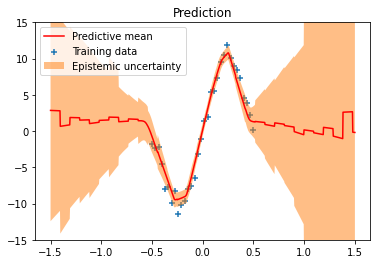

In [370]:
import tqdm

X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)

y_pred_list = []
y_sigma_list = []
for i in tqdm.tqdm(range(100)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)

    
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.ylim(-15,15)
plt.legend();


We can see that a Bayesian neural network is able to capture the epistemic uncertainty due to our uncertainty on the values the model parameters should take on. 

In this example we didn't train on the bias term to keep the problem simple. But let's try to do it now for completeness.

In order to consider the uncertainty on the bias term we need to define a posterior distribution over the bias as well . We assume the same approximate posterior, so that $b = b_{\mu} + b_{\sigma} * \epsilon$ and we use the same transformation for $\sigma(\rho)$. Thus, we can train on $\mathbf{b}$ in the same way we train on the other weights. 

In [371]:

class DenseVariationalComplete(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        #kernel
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                         trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)

        #bias
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.RandomNormal(stddev=self.init_sigma),
                                       trainable=True)

        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))

In [372]:
# Change input vector shape from (1,) to (2,)
x_in = Input(shape=(1,))
x = DenseVariationalComplete(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariationalComplete(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariationalComplete(1, kl_weight, **prior_params)(x)

model2 = Model(x_in, x)

In [373]:
model2.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.08), metrics=['mse'])
history = model2.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0);

100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


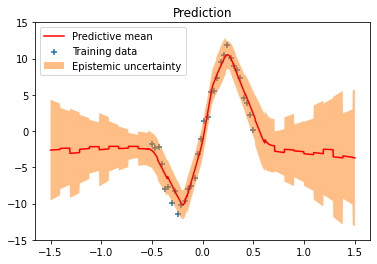

In [374]:
y_pred_list = []

for i in tqdm.tqdm(range(100)):
    y_pred = model2.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.ylim(-15,15)
plt.legend();

Note how the epistemic uncertainty reported in the region where we have training data is larger. This is because now we are including also the uncertainty on the bias paramater. 

## Conclusion

In this notebook we have followed the approach described in the paper *Weight Uncertainty in Neural Networks* to building a neural network with variational layers. We saw how by using a variational layer we can train also on the uncertainty of the model parameters. This allows us to take into account the epistemic uncertainty in our predictions, as each prediction is obtained by drawing a random weight configuration from the postrior distribution. The result is an ensemble of neural networks which we can describe with standard MC sampling statistics. Note however that the model does not address the aleatoric in the data. We will cover this in the next notebook. 